<center><font size=6><b>GEOS 669 Geodetic Methods and Modeling</b></font></center>

# Lab 08: Volcano Deformation

### Introduction

Today you will use some co-eruptive displacements from Redoubt volcano's 2009 eruption and hopefully learn a bit about its source. You will do 2 things: (1) implement the Mogi model, (2) find the best source parameters given the displacements.

Caveats:

(1) [I've already shown](http://www.grapenthin.org/download/Grapenthin_etal2012_Redoubt.pdf) that the Mogi source isn't the best model for the co-eruptive phase. We'll use it anyway for the data, because it's a simple model, and we're here to learn the methods.

(2) The method I'll have you implement to solve for the non-linear parts is inefficient and imprecise. Again, it's one way to gain an intuition to find solutions to these problems; you should embark on a journey to learn about the many efficient non-linear methods / solvers that are out there yourself; often they take a parameter range in which they do their magic, which reduces to a single function call. Using this wouldn't result in much learning in a lab.

I bring up these points to make sure you don't assume the methods used here are the ones you should use for the rest of your career; far from it! They're a starting point.

### The Forward Model

First, start out with implementing a function `dr, dz = mogi(x,y,d,C)`, which - given a set of distances (`x`,`y`) in Carthesian coordinates away from a source location, a source depth `d` and a source strength `C` - returns radial and horizontal displacements at these points according to the Mogi model (check slides for formulas).

You can test your model with these values:


```
mogi(    np.array([1000, -1000, 2000, 0]).reshape(4,1), 
         np.array([1000, -1000, 2000, 0]).reshape(4,1), 
         17000, 
         (0.75*0.05*pow(1000,3))/np.pi
    )

dr =

   0.003400610640462
   0.003400610640462
   0.006596168094920
                   0


dz =

   0.040878112348779
   0.040878112348779
   0.039645659112996
   0.041303185923502			
```

The `x`,`y` distances are in meters away from a source at 17 km depth that changes in volume by 0.05 km3. **What are the units of `dr`, `dz`?**

In [1]:
import numpy as np

In [2]:
#write your mogi function here

In [3]:
#check your mogi funtion here

**Answer the question here:**


### The "Inverse" Model

Below we create a matrix `displacements`; its contents is described in the comments and a vector `volcano` which contains in UTM coordinates (meters) the location of the volcano.

The network setup is shown in the figure here:

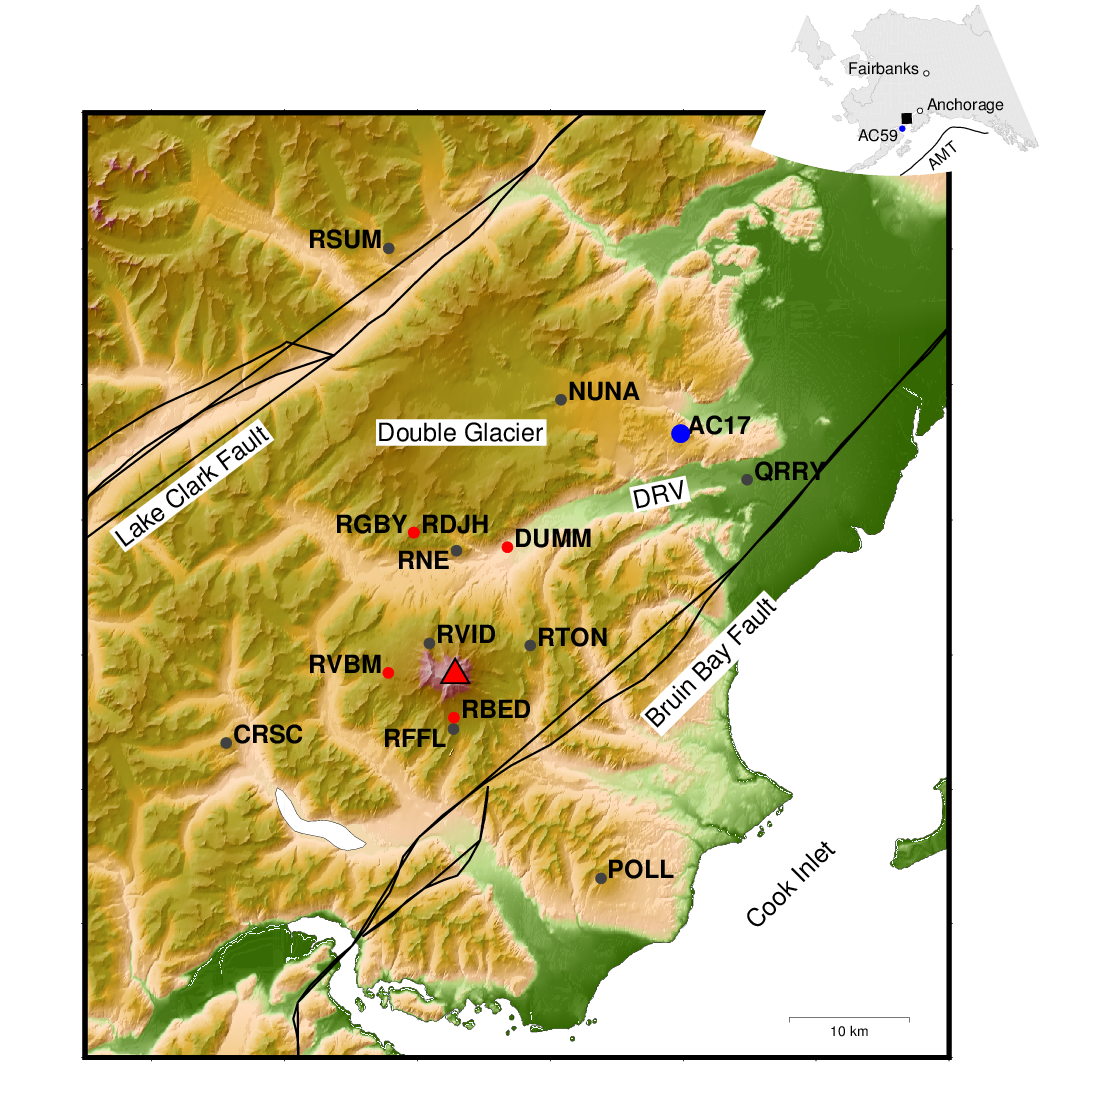

In [6]:
from IPython import display
display.Image("redoubt.png")

In [7]:
#Assemble the displacements maxtrix
#station = [UTM-E (m) UTM-N (m) ur (cm)  uz (cm)]
AC17 = [532583.0, 6725499.7, -0.65, -0.39]
DUMM = [518386.5, 6716046.4, -1.10, -1.65]
RBED = [514033.1, 6701953.2, -0.64, -2.63]
RVBM = [508593.5, 6705638.3, -0.68, -2.59]

displacements = np.vstack((AC17, DUMM, RBED, RVBM))

#create the volcano vector
#UTM location of Redoubt volcano
volcano = [513081.0, 6705989.0]

Write a script that searches within +/-10 km of the volcano's location, within a depth range of, say, 40 km for a Mogi source. Note that the Mogi model is non-linear with respect to location and hence you'll need to come up with a non-linear solution scheme. I'd recommend you do a grid search in 1 km intervals through your model domain. You can invert for your source strength `C` using least-squares since the model is linear in that parameter.

To repeat, this is not the best way to solve this problem, but it provides considerable intuition as to what more sophisticated methods might be after.

**Hints**

A few things you need to do (Test each step individually! Do not try to slay the entire beast in one fell swoop!):

- setup your data vector concatenating `ur`, `uz` in correct units
- turn the global coordinates of the stations to radial distances with respect to the volcano location (subtract volcano location)
- set a new variable `current_resid_norm=np.Inf`
- write loops to iterate over `x`, `y`, depth `d`
- set up your design matrix `G` to solve for `C` in the innermost loop (depends on `r`, `d`)
- invert for `C` - the source strength
- compute the forward model using the `mogi` function you've written before. The parameter values for this function call will be the `x`,`y`,`d` values from the triple loop you are in. `C` will come from the least squares solution just calculated.
- calculate the norm of the residual vector
- if your new norm is better than any of the previous norms, save your current model parameters in variables, say, `best_x`, `best_y`, `best_d`, `best_C`; save this currently best `norm in current_resid_norm`

**What is the expected source depth and the volume change of the magma reservoir (convert from source strength to volume (see lecture slides and above)!)? Give these values in sensible units. Compare and discuss the radial and vertical displacement observations and the results you'd get from the Mogi model with your best fitting model residuals.**



In [8]:
#write your script here:

**Answer the questions here:**
